In [77]:
from mnist import MNIST 
import numpy as np

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [328]:
labels = mndata.train_labels
# np.where(np.isin(labels,[2]))[0][0]
# np.where(labels == 1)
cluster_size = 10
train_inputs_idx = []
for idx in range(10):
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

100

In [337]:
layer_size = 10*4

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size) * 0.001
print('W', W.shape, W.max(), W.min())

push_delta = 0.4
k = 1

syn_n = 0.5
syn_size = W.shape[1]
W_idx = np.arange(syn_size)
W_len = np.abs(W_idx[np.newaxis].T - W_idx)
W_len = (np.array(W_len, dtype='float') + 1) ** -syn_n

epoch_cnt = 100
# i_idx = 10
eps0 = 0.02

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    for i_idx in samples_idx:
        img = mndata.train_images[i_idx]

        # infer
        I = np.array(img) / 255
        O = np.dot(W, I)

        # train
        dW = I - (W * O[np.newaxis].T)
        wO = np.argsort(O)[::-1]
        O.fill(0)
        O[wO[0]] = 1
        O[wO[1:1+k]] = -push_delta
        dW *= O[np.newaxis].T
        dW *= eps

        # local synapse reinforcement
        dLNR = np.dot(W, W_len)
        # dLNR = dLNR / np.abs(np.max(dLNR))
        # dLNR -= np.min(dLNR)
        dLNR *= eps
        dW *= dLNR

        # update
        dW = dW / np.abs(np.max(dW))
        W += dW

    # remove weak synapses
    # for nW in W:
    #     nW[np.where(np.abs(nW) < 1.0 * np.median(np.abs(nW)))] = 0
    WTr_coef = 1.0
    WTr = WTr_coef * np.median(np.abs(W), axis=1)
    W[np.where(np.abs(W) < WTr[np.newaxis].T)] = 0

print(W.size, np.sum(W == 0), np.sum(W != 0) / np.sum(W == 0))


W (40, 784) 0.0009999984680401767 2.7618634712234248e-08
31360 15680 1.0


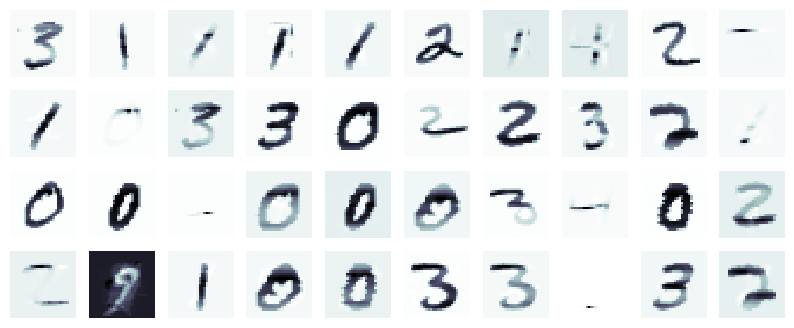

In [336]:
from pylab import *
%matplotlib inline
row_size = 10
col_size = int(layer_size / row_size)

figure(figsize=(row_size, col_size))

for col_idx in range(col_size):
    for row_idx in range(row_size):
        n_W_idx = col_idx * row_size + row_idx

        aimg = W[n_W_idx].reshape(img_side, img_side)

        subplot(col_size, row_size, n_W_idx + 1)

        imshow(aimg, interpolation='none', aspect='auto', cmap='bone')
        axis("off")

show()
